# French to English translation with a Seq2Seq network and attention

In this notebook we shall train a neural network to translate from **French** to **English**.

We shall use Seq2Seq RNN with attention.

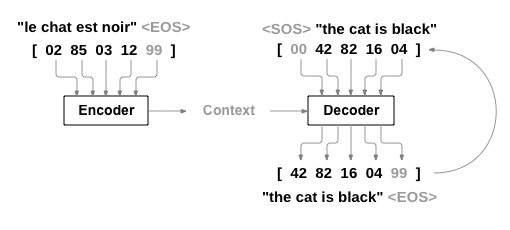

The notebook is taken from [NLP From Scratch: Translation with a Sequence to Sequence Network and Attention](https://docs.pytorch.org/tutorials/intermediate/seq2seq_translation_tutorial.html).

## Importing necessary libraries

In [1]:
from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import re
import random

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

import numpy as np
from torch.utils.data import TensorDataset, DataLoader, RandomSampler

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


## Loading the data and preprocessing 

The data for this project is a set of many thousands of English to French translation pairs.

Download the data from [here](https://download.pytorch.org/tutorial/data.zip) and extract it to the current directory.

The file name is "eng-fra.txt". I have also provided this file in the github. The file is a tab separated list of translation pairs:
```
I am cold.    J'ai froid.
```

We’ll need a unique index per word to use as the inputs and targets of the networks later. To keep track of all this we will use a helper class called Lang which has word → index (`word2index`) and index → word (`index2word`) dictionaries, as well as a count of each word `word2count` which will be used to replace rare words later.

In [2]:
SOS_token = 0
EOS_token = 1

class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS"}
        self.n_words = 2  # Count SOS and EOS

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

The files are all in Unicode, to simplify we will turn Unicode characters to ASCII, make everything lowercase, and trim most punctuation.

In [3]:
# Turn a Unicode string to plain ASCII, thanks to
# https://stackoverflow.com/a/518232/2809427

def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

# Lowercase, trim, and remove non-letter characters
def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z!?]+", r" ", s)
    return s.strip()

To read the data file we will split the file into lines, and then split lines into pairs. The files are all English → Other Language, so if we want to translate from Other Language → English, there is the `reverse` flag to reverse the pairs.

By default reverse is False implying lang1 to lang2 translation, if reverse is True then that implies lang2 to lang1 translation.

In [4]:
def readLangs(lang1, lang2, file_path, reverse=False):
    print("Reading lines...")

    # Read the file and split into lines
    lines = open(file_path, encoding='utf-8').read().strip().split('\n')

    # Split every line into pairs and normalize
    pairs = [[normalizeString(s) for s in l.split('\t')] for l in lines]

    # Reverse pairs, make Lang instances
    if reverse:
        pairs = [list(reversed(p)) for p in pairs]
        input_lang = Lang(lang2)
        output_lang = Lang(lang1)
    else:
        input_lang = Lang(lang1)
        output_lang = Lang(lang2)

    return input_lang, output_lang, pairs

Since there are a lot of example sentences and we want to train something quickly, we’ll trim the data set to only relatively short and simple sentences. 

Here the maximum length is 10 words and we’re filtering to sentences that translate to the form “I am” or “He is” etc. (accounting for apostrophes replaced earlier).

In [5]:
MAX_LENGTH = 10

eng_prefixes = (
    "i am ", "i m ",
    "he is", "he s ",
    "she is", "she s ",
    "you are", "you re ",
    "we are", "we re ",
    "they are", "they re "
)

def filterPair(p):
    return len(p[0].split(' ')) < MAX_LENGTH and \
        len(p[1].split(' ')) < MAX_LENGTH and \
        p[1].startswith(eng_prefixes)


def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]

The full process for preparing the data is:

- Read text file and split into lines, split lines into pairs

- Normalize text, filter by length and content

- Make word lists from sentences in pairs

In [6]:
def prepareData(lang1, lang2, file_path, reverse=False):
    input_lang, output_lang, pairs = readLangs(lang1, lang2, file_path, reverse)
    print(f"Read {len(pairs)} sentence pairs")
    pairs = filterPairs(pairs)
    print(f"Trimmed to {len(pairs)} sentence pairs")
    print("Counting words...")
    for pair in pairs:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
    print("Counted words:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    return input_lang, output_lang, pairs

input_lang, output_lang, pairs = prepareData('english', 'french', "./eng-fra.txt", True)
print(f"Input language: {input_lang.name}, Output language: {output_lang.name}")
print(f"Sample pair: {random.choice(pairs)}")

Reading lines...
Read 135842 sentence pairs
Trimmed to 11445 sentence pairs
Counting words...
Counted words:
french 4601
english 2991
Input language: french, Output language: english
Sample pair: ['elles sont cinq en tout', 'they are five in all']


## The Seq2Seq Model

The Seq2Seq model comprises of two sub-networks:

**The Encoder:** The encoder of a seq2seq network is a RNN that outputs some value for every word from the input sentence. For every input word the encoder outputs a vector and a hidden state, and uses the hidden state for the next input word.

**The Decoder:** The decoder is another RNN that takes the encoder output vector(s) and outputs a sequence of words to create the translation.

The decoder will be implemented with attention mechanism.

### The Encoder RNN

The Encoder is implemented with the `EncoderRNN` class with its own `forward` method.

Schematic of Encoder RNN:

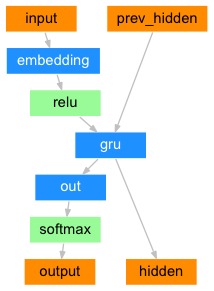

Note that in our implementation we have used GRU (a type of RNN). You can also use normal RNN or LSTM in place of GRU.

In [7]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size, dropout_p=0.1):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, batch_first=True)
        # We can also use LSTM here instead of GRU
        # self.lstm = nn.LSTM(hidden_size, hidden_size, batch_first=True)
        self.dropout = nn.Dropout(dropout_p)

    def forward(self, input):
        embedded = self.dropout(self.embedding(input))
        output, hidden = self.gru(embedded)
        return output, hidden

### The Attention Mechanism

We have implemented two attention mechanism. Any one of them can be used in subsequent decoder class.

**The Bahdanau Attention**: It is implemented using `BahdanauAttention` class.

**The Luong Attention**: It is implemented using `LuongAttention` class.

Note: While implementing the attention mechanism we have assumed same size for both encoder and decoder hidden states. However with minor changes the same code can be adapted for different encoder and decoder hidden sizes. 

### BahdanauAttention class

In [8]:
class BahdanauAttention(nn.Module):
    def __init__(self, hidden_size):
        super(BahdanauAttention, self).__init__()
        # Ws matrix projects decoder hidden state (query) into a common space
        self.Ws = nn.Linear(hidden_size, hidden_size, bias=False) # Transforms the decoder hidden state
        # Wh matrix projects decoder hidden state (query) into a common space
        self.Wh = nn.Linear(hidden_size, hidden_size, bias=False) # transforms the encoder outputs
        # Va is used to convert the combined representation into a score
        self.Va = nn.Linear(hidden_size, 1)

    def forward(self, decoder_hidden, encoder_outputs):
        """
        Forward pass of the Bahdanau attention mechanism.

        Args:
        - decoder_hidden: tensor of shape [batch_size, 1, hidden_size]
                          current decoder hidden state (after unsqueeze so it's 1 time-step)
                          decoder_hidden is also called "query" in attention literature
        - encoder_outputs: tensor of shape [batch_size, seq_len, hidden_size]
                           all encoder output hidden states (one for each input position)
                           encoder_outputs is also called "keys" in attention literature
        Returns:
        - context: tensor of shape [batch_size, 1, hidden_size]
                   the weighted sum of the keys, according to attention weights
        - attention_weights: tensor of shape [batch_size, 1, seq_len]
                             attention weight of each encoder position for this decoder step
        """

        # Project the decoder_hidden state (query) into the "attention space"
        # Result shape: [batch_size, 1, hidden_size]
        projected_decoder_hidden = self.Ws(decoder_hidden)

        # Project the encoder_outputs (keys) into the "attention space"
        # Result shape: [batch_size, seq_len, hidden_size]
        projected_encoder_outputs = self.Wh(encoder_outputs)

        # Compute "alignment scores" by combining decoder_hidden (query) and encoder_outputs (keys).
        # We add the broadcasted projected_decoder_hidden (projected_query) to projected_encoder_outputs (projected_keys),
        # apply tanh non-linearity, then project to scalar scores with Va.
        # computed attn_scores shape = [batch_size, seq_len, 1]
        attn_scores = self.Va(torch.tanh(projected_decoder_hidden + projected_encoder_outputs))

        # .squeeze(2)  remove the last dimension -> [batch_size, seq_len]
        # .unsqueeze(1) add dimension back for attention weights shape -> [batch_size, 1, seq_len]
        # final attn_scores shape = [batch_size, 1, seq_len]
        attn_scores = attn_scores.squeeze(2).unsqueeze(1)

        # softmax across the sequence dimension (dim = -1 i.e. seq_len)
        # attention_weights shape: [batch_size, 1, seq_len]
        attention_weights = F.softmax(attn_scores, dim=-1)

        # context shape: [batch_size, seq_len, hidden_size]
        # attention_weights shape: [batch_size, 1, seq_len]
        # context shape: [batch_size, 1, hidden_size]
        context = torch.bmm(attention_weights, encoder_outputs) # bmm stands for batch matrix multiplication

        return context, attention_weights

### LuongAttention class

In [9]:
class LuongAttention(nn.Module):
    def __init__(self, hidden_size):
        super(LuongAttention, self).__init__()
        # In "general" form we have a weight matrix W_a of size (hidden_size × hidden_size)
        self.Wa = nn.Linear(hidden_size, hidden_size, bias=False)
        
    def forward(self, decoder_hidden, encoder_outputs):
        """
        Forward pass of the Luong attention mechanism.
        
        Args:
        - decoder_hidden (Tensor): Hidden state of the decoder, shape (batch_size, 1, hidden_size)
        - encoder_outputs (Tensor): Hidden states of the encoder, shape (batch_size, seq_len, hidden_size)
        
        Returns:
        - context: [batch_size, 1, hidden_size]
        - attn_weights: [batch_size, 1, seq_len]
        """

        # Transform encoder_outputs using W_a
        # encoder_transformed shape: [batch_size, seq_len, hidden_size]
        encoder_transformed = self.Wa(encoder_outputs)

        # Calculate attention scores = decoder_hidden · encoder_transformed^T
        # decoder_hidden shape: [batch_size, 1, hidden_size]
        # encoder_transformed.transpose(1,2) shape: [batch_size, hidden_size, seq_len]
        
        attn_scores = torch.bmm(decoder_hidden, encoder_transformed.transpose(1, 2))
        
        # Normalize with softmax over seq_len dimension
        attention_weights = torch.softmax(attn_scores, dim=-1) # [batch_size, 1, seq_len]
 
        # Compute context vector as weighted sum of encoder_outputs
        # attention_weights shape: [batch_size, 1, seq_len]
        # encoder_outputs shape:    [batch_size, seq_len, hidden_size]

        context = torch.bmm(attention_weights, encoder_outputs)  # [batch_size, 1, hidden_size]
        
        return context, attention_weights

### The Decoder RNN

We have implemented `AttnDecoderRNN` which implements decoder RNN with attention and teacher forcing (explained below).

Schematic of Decoder RNN with attention:

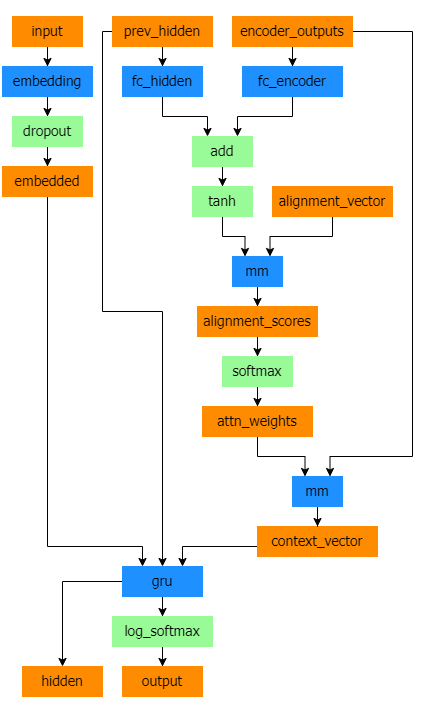

### Teacher Forcing

- Teacher forcing is a training technique used in sequence generation models, particularly in sequence-to-sequence models like encoder-decoder architectures. In these models, during training, the input to the decoder at each time step is not necessarily the previously generated token but rather the actual target token from the training data.

- During Training:

    - Instead of using the decoder's output from the previous time step as the input to the current time step (as is done during inference), the model is fed with the ground truth target token for the current time step.
    
    - This means that at each time step, the input to the decoder is the actual token from the target sequence rather than the token predicted by the model.
    
    - This helps to stabilize and expedite training by providing more accurate information to the model during training, as it learns to predict the next token based on the correct preceding tokens.

- During Inference (Actual Generation):
    - When generating sequences during inference (i.e., when the model is used to produce output on unseen data), the model typically uses its own predictions from the previous time step as the input to the current time step.
    
    - Teacher forcing is not used during inference because during actual generation, the model won't have access to the ground truth target tokens.

Because of the freedom PyTorch’s autograd gives us, we can randomly choose to use teacher forcing or not with a simple if statement. Turn `teacher_forcing_ratio` up to use more of it.

In [10]:
class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1, teacher_forcing_ratio=0.5):
        super(AttnDecoderRNN, self).__init__()
        self.embedding = nn.Embedding(output_size, hidden_size)
        # self.attention = BahdanauAttention(hidden_size) 
        self.attention = LuongAttention(hidden_size)
        self.gru = nn.GRU(2 * hidden_size, hidden_size, batch_first=True)
        self.out = nn.Linear(hidden_size, output_size)
        self.dropout = nn.Dropout(dropout_p)
        self.teacher_forcing_ratio = teacher_forcing_ratio

    def forward_step(self, input, hidden, encoder_outputs):
        embedded =  self.dropout(self.embedding(input))

        query = hidden.permute(1, 0, 2)
        context, attn_weights = self.attention(query, encoder_outputs)
        input_gru = torch.cat((embedded, context), dim=2)

        output, hidden = self.gru(input_gru, hidden)
        output = self.out(output)

        return output, hidden, attn_weights

    def forward(self, encoder_outputs, encoder_hidden, target_tensor=None):
        batch_size = encoder_outputs.size(0)
        decoder_input = torch.empty(batch_size, 1, dtype=torch.long, device=device).fill_(SOS_token)
        decoder_hidden = encoder_hidden
        decoder_outputs = []
        attentions = []

        for i in range(MAX_LENGTH):
            decoder_output, decoder_hidden, attn_weights = self.forward_step(
                decoder_input, decoder_hidden, encoder_outputs
            )
            decoder_outputs.append(decoder_output)
            attentions.append(attn_weights)

            if target_tensor is not None and random.random() < self.teacher_forcing_ratio:
                # Teacher forcing: Feed the target as the next input
                decoder_input = target_tensor[:, i].unsqueeze(1) # Teacher forcing
            else:
                # Without teacher forcing: use its own predictions as the next input
                _, topi = decoder_output.topk(1)
                decoder_input = topi.squeeze(-1).detach()  # detach from history as input

        decoder_outputs = torch.cat(decoder_outputs, dim=1)
        decoder_outputs = F.log_softmax(decoder_outputs, dim=-1)
        attentions = torch.cat(attentions, dim=1)

        return decoder_outputs, decoder_hidden, attentions

## Training Utility

### Preparing Training Data

To train, for each pair we will need an input tensor (indexes of the words in the input sentence) and target tensor (indexes of the words in the target sentence). While creating these vectors we will append the EOS token to both sequences.

In [11]:
def indexesFromSentence(lang, sentence):
    return [lang.word2index[word] for word in sentence.split(' ')]

def tensorFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(1, -1)

def tensorsFromPair(pair):
    input_tensor = tensorFromSentence(input_lang, pair[0])
    target_tensor = tensorFromSentence(output_lang, pair[1])
    return (input_tensor, target_tensor)

def get_dataloader(batch_size, pairs):

    n = len(pairs)
    input_ids = np.zeros((n, MAX_LENGTH), dtype=np.int32)
    target_ids = np.zeros((n, MAX_LENGTH), dtype=np.int32)

    for idx, (inp, tgt) in enumerate(pairs):
        inp_ids = indexesFromSentence(input_lang, inp)
        tgt_ids = indexesFromSentence(output_lang, tgt)
        inp_ids.append(EOS_token)
        tgt_ids.append(EOS_token)
        input_ids[idx, :len(inp_ids)] = inp_ids
        target_ids[idx, :len(tgt_ids)] = tgt_ids

    train_data = TensorDataset(torch.LongTensor(input_ids).to(device),
                               torch.LongTensor(target_ids).to(device))

    train_sampler = RandomSampler(train_data)
    train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)
    return input_lang, output_lang, train_dataloader

### Utility to training the Model

To train we run the input sentence through the encoder, and keep track of every output and the latest hidden state. Then the decoder is given the <SOS> token as its first input, and the last hidden state of the encoder as its first hidden state.

In [12]:
def train_epoch(dataloader, encoder, decoder, encoder_optimizer,
          decoder_optimizer, criterion):

    total_loss = 0
    for data in dataloader:
        input_tensor, target_tensor = data

        encoder_optimizer.zero_grad()
        decoder_optimizer.zero_grad()

        encoder_outputs, encoder_hidden = encoder(input_tensor)
        decoder_outputs, _, _ = decoder(encoder_outputs, encoder_hidden, target_tensor)

        loss = criterion(
            decoder_outputs.view(-1, decoder_outputs.size(-1)),
            target_tensor.view(-1)
        )
        loss.backward()

        encoder_optimizer.step()
        decoder_optimizer.step()

        total_loss += loss.item()

    return total_loss / len(dataloader)

These are helper functions to print time elapsed and estimated time remaining given the current time and progress %

In [13]:
import time
import math

def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%2dm %2ds' % (m, s)

def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return 'Elapsed time: %s (Approx. remaining time: %s)' % (asMinutes(s), asMinutes(rs))

The whole training process looks like this:

- Start a timer

- Initialize optimizers and criterion

- Create set of training pairs

- Start empty losses array for plotting

Then we call train many times and occasionally print the progress (% of examples, time so far, estimated time) and average loss.

In [14]:
def train(train_dataloader, encoder, decoder, n_epochs, learning_rate=0.001,
               print_every=5, plot_every=5):
    start = time.time()
    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every

    encoder_optimizer = optim.Adam(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.Adam(decoder.parameters(), lr=learning_rate)
    criterion = nn.NLLLoss()

    for epoch in range(1, n_epochs + 1):
        loss = train_epoch(train_dataloader, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss

        if epoch % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s | Epoch: %3d | Percentage Completion: %3d%% | average training loss: %.4f' % (timeSince(start, epoch / n_epochs),
                                    epoch, epoch / n_epochs * 100, print_loss_avg))

        if epoch % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0

    return plot_losses

## Evaluation Utility

Evaluation is mostly the same as training, but there are no targets so we simply feed the decoder’s predictions back to itself for each step. Every time it predicts a word we add it to the output string, and if it predicts the EOS token we stop there. We also store the decoder’s attention outputs for display later.

In [15]:
def evaluate(encoder, decoder, sentence, input_lang, output_lang):
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence)

        encoder_outputs, encoder_hidden = encoder(input_tensor)
        decoder_outputs, decoder_hidden, decoder_attn = decoder(encoder_outputs, encoder_hidden)

        _, topi = decoder_outputs.topk(1)
        decoded_ids = topi.squeeze()

        decoded_words = []
        for idx in decoded_ids:
            if idx.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            decoded_words.append(output_lang.index2word[idx.item()])
    return decoded_words, decoder_attn

We can evaluate random sentences from the training set and print out the input, target, and output to make some subjective quality judgements:

In [16]:
def evaluateRandomly(encoder, decoder, n=10):
    for i in range(n):
        pair = random.choice(pairs)
        print('>', pair[0])
        print('=', pair[1])
        output_words, _ = evaluate(encoder, decoder, pair[0], input_lang, output_lang)
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        print('')

## Training and Evaluating models

### Defining the networks

In [17]:
HIDDEN_SIZE = 128
BATCH_SIZE = 32
EPOCHS = 20

input_lang, output_lang, train_dataloader = get_dataloader(BATCH_SIZE, pairs)

encoder = EncoderRNN(input_lang.n_words, HIDDEN_SIZE, dropout_p=0.2).to(device)
decoder = AttnDecoderRNN(HIDDEN_SIZE, output_lang.n_words, dropout_p=0.2, teacher_forcing_ratio=0.5).to(device)

traning_losses = train(train_dataloader, encoder, decoder, EPOCHS, print_every=1, plot_every=1)

Elapsed time:  0m 16s (Approx. remaining time:  5m 18s) | Epoch:   1 | Percentage Completion:   5% | average training loss: 2.7925
Elapsed time:  0m 31s (Approx. remaining time:  4m 39s) | Epoch:   2 | Percentage Completion:  10% | average training loss: 2.0640
Elapsed time:  0m 42s (Approx. remaining time:  3m 58s) | Epoch:   3 | Percentage Completion:  15% | average training loss: 1.8546
Elapsed time:  0m 52s (Approx. remaining time:  3m 30s) | Epoch:   4 | Percentage Completion:  20% | average training loss: 1.7069
Elapsed time:  1m  3s (Approx. remaining time:  3m 10s) | Epoch:   5 | Percentage Completion:  25% | average training loss: 1.5979
Elapsed time:  1m 14s (Approx. remaining time:  2m 52s) | Epoch:   6 | Percentage Completion:  30% | average training loss: 1.4949
Elapsed time:  1m 25s (Approx. remaining time:  2m 37s) | Epoch:   7 | Percentage Completion:  35% | average training loss: 1.4050
Elapsed time:  1m 36s (Approx. remaining time:  2m 24s) | Epoch:   8 | Percentage C

### Plotting training losses.

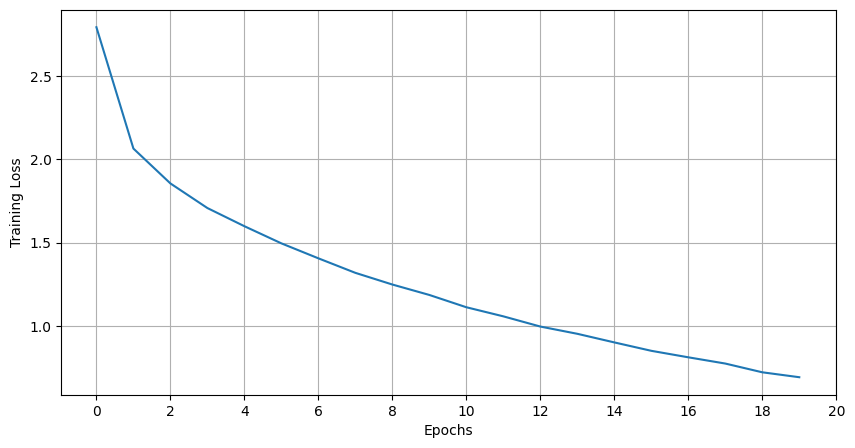

In [18]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.plot(traning_losses)
plt.xlabel('Epochs')
plt.ylabel('Training Loss')
plt.xticks(range(0, EPOCHS+1, 2))
plt.grid()
plt.show()

### Setting the network to eval mode for evaluation and performing evaluation

In [19]:
encoder.eval()
decoder.eval()
evaluateRandomly(encoder, decoder)

> vous etes tres religieuse n est ce pas ?
= you re very religious aren t you ?
< you re very religious aren t you ? <EOS>

> vous n etes pas faciles a trouver
= you re not easy to find
< you re not allowed to eat those <EOS>

> nous sommes toutes celibataires
= we re all single
< we re all the same same <EOS>

> il est de loin le meilleur etudiant
= he is by far the best student
< he is a of the the best student <EOS>

> vous etes une etudiante
= you are a student
< you re a woman woman woman woman <EOS>

> c est une gentille fille
= she s a sweet girl
< she s a very and and girl <EOS>

> je suis impulsif
= i m impulsive
< i m really sorry about last <EOS>

> ils sont contents du resultat
= they are happy with the result
< they are responsible where they the result they <EOS>

> nous n allons pas en vacances
= we are not going on vacation
< we re not going to make it this <EOS>

> je suis assez fatiguee
= i m quite tired
< i m pretty tired and tired and tired <EOS>



## Visualizing Attention

A useful property of the attention mechanism is its highly interpretable outputs. Because it is used to weight specific encoder outputs of the input sequence, we can imagine looking where the network is focused most at each time step.

You could simply run plt.matshow(attentions) to see attention output displayed as a matrix. For a better viewing experience we will do the extra work of adding axes and labels

input = il n est pas aussi grand que son pere
output = he is not as tall as his father <EOS>


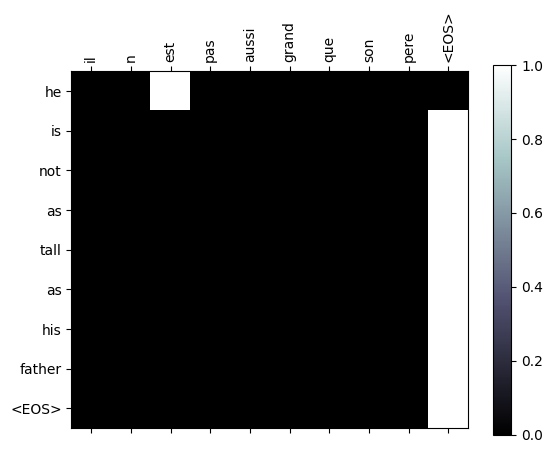

input = je suis trop fatigue pour conduire
output = i m too tired to see him <EOS>


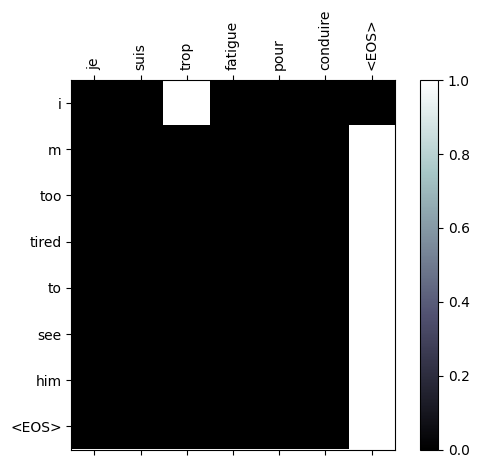

input = je suis desole si c est une question idiote
output = i m sorry but you have a a boyfriend <EOS>


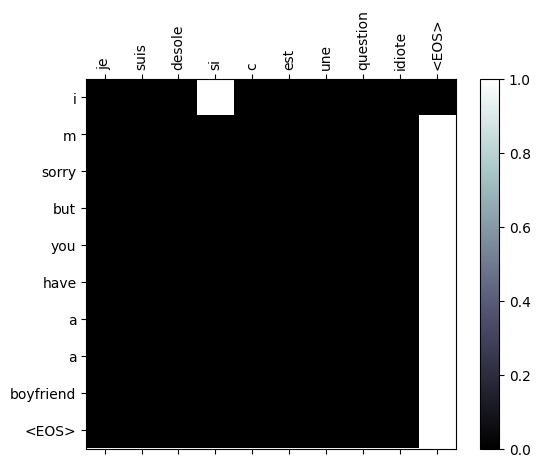

input = je suis reellement fiere de vous
output = i m so proud of you you you <EOS>


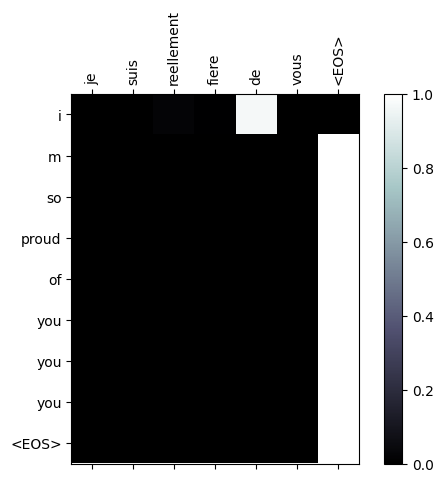

In [20]:
import matplotlib.ticker as ticker

def showAttention(input_sentence, output_words, attentions):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions.cpu().numpy(), cmap='bone')
    fig.colorbar(cax)

    # Tokenize the input and output
    input_tokens = input_sentence.split(' ') + ['<EOS>']
    output_tokens = output_words

    # Set tick positions to match token count
    ax.set_xticks(range(len(input_tokens)))
    ax.set_yticks(range(len(output_tokens)))

    # Set up axes
    ax.set_xticklabels(input_tokens, rotation=90)
    ax.set_yticklabels(output_tokens)

    # Ensure tick at every token (avoid skipping)
    ax.xaxis.set_major_locator(ticker.FixedLocator(range(len(input_tokens))))
    ax.yaxis.set_major_locator(ticker.FixedLocator(range(len(output_tokens))))

    plt.show()


def evaluateAndShowAttention(input_sentence):
    output_words, attentions = evaluate(encoder, decoder, input_sentence, input_lang, output_lang)
    print('input =', input_sentence)
    print('output =', ' '.join(output_words))
    showAttention(input_sentence, output_words, attentions[0, :len(output_words), :])


evaluateAndShowAttention('il n est pas aussi grand que son pere')

evaluateAndShowAttention('je suis trop fatigue pour conduire')

evaluateAndShowAttention('je suis desole si c est une question idiote')

evaluateAndShowAttention('je suis reellement fiere de vous')

## Improvements and Further Work

1. **Use BLEU score to numerically evaluate the performance:**

Split the the data in train and test and use BLEU score to quantify the performance of the model on unseen (test) data.

2. **Increase training samples:**

We have only used a fraction of our training samples. Use more data to train the model.

3. **Increase network size:**

As you increase the number of training samples use larger networks (more layers, more hidden units). Compare the training time and results.

4. **Try different language:**

Use other parallel language corpus to train the NMT model.

5. **Try different seq2seq usecase:**

These architecture is suitable for other usecases, such as: text summarization, question answering etc.
